<a href="https://colab.research.google.com/github/davidabelin/doubledigits/blob/main/double_digits_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Everything not mine is copyright 2020 Google LLC. Double-click here for full information.
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Yann LeCun and Corinna Cortes hold the copyright of MNIST dataset,
# which is a derivative work from original NIST datasets. 
# MNIST dataset is made available under the terms of the 
# Creative Commons Attribution-Share Alike 3.0 license.

This Notebook is heavily modified from the MLCC programming project with single-digit images here:
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/cc/exercises/multi-class_classification_with_MNIST.ipynb

**[Taken from the original MLCC "project" with single digit images. I will start with these images and then merge them together, pixel-array by pixel-array, to create a new train/test set of 100 double-digit images.]**

In [ ]:
# load some standard utilities.
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import random as rd
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.3f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

print("Loaded modules.")

Loaded modules.


In [ ]:
# load the dataset.
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("Loaded the train and test sets.")

11493376/11490434 [==============================] - 0s 0us/step
Loaded the train and test sets.


Loaded function doubleDigits.
Loaded the plot_curve function to be called after training.
Loaded function getDoubleDigits.
Random example:
Answer: 87


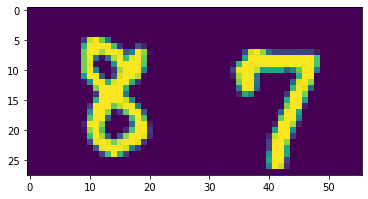

In [ ]:
# <-- click the "play" button to run this cell!
#@title Click button on left to run and double-click on text to show/hide some code.
# 
# THE CODE IN THIS CELL DEFINES FOR VARIOUS FUNCTIONS 
# I'LL USE LATER. I WROTE THESE UP IN PYTHON MYSELF.
# IT WILL BE MOSTLY MY CODE FROM HERE ON.
#
# **BTW** YOU HAVE TO RUN EACH CELL IN THE NOTEBOOK, IN ORDER! 
# IF YOU MISS ONE, YOU'LL GET ERROR MESSAGES LATER ON. IF THAT
# HAPPENS JUST GO BACK AND MAKE SURE YOU HAVE CLICKED ON ALL
# THE LITTLE 'PLAY' BUTTONS UP TO WHERE YOU ARE.
#
# THIS FUNCTION MERGES TWO RANDOMLY CHOSEN SINGLE-DIGIT IMAGES
# INTO ONE DOUBLE-DIGIT IMAGE REPRESENTING NUMBERS 0 TO 99.
# THE "CORRECT ANSWER" FOR THE DOUBLE-DIGIT IMAGE IS CALCULATED
# FROM THE ANSWERS GIVEN FOR THE SINGLE-DIGIT IMAGES (IN Y_TRAIN
# AND Y_TEST).

def doubleDigits(images=x_train,answers=y_train):
    im = np.array([28,56])
    im.resize((28,56))
    tens = rd.randint(0,len(images)-1) # HERE IS WHERE THE 
    ones = rd.randint(0,len(images)-1) # RANDOM NUMS COME FROM
    dubs = images[tens].copy()             # IMAGE ON THE LEFT
    digs = images[ones].copy()             # IMAGE ON THE RIGHT
    for i,col in enumerate(dubs.transpose()):
        im[:,i] = col
    for i,col in enumerate(digs.transpose()):
        im[:,i+28] = col
    answer = answers[tens]*10 + answers[ones] #CALCULATE THE RIGHT
    return im, answer                         #ANSWER NUMERICALLY                
    #returns image array, list of answers
print("Loaded function doubleDigits.")

def plot_curve(epochs, hist, metric):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  x = hist[metric]
  plt.plot(epochs[1:], x[1:], label=metric)

  plt.legend()

print("Loaded the plot_curve function to be called after training.")

# THIS FUNCTION WILL BE CALLED TO GENERATE A NEW 
# TRAINING SET OF RANDOM DOUBLE-DIGIT IMAGES TO WORK WITH

def getDoubleDigits(x_df=x_train,y_df=y_train,how_many=1):
    '''
        Get a trainable set of how_many double-digit images. 
        Returns two objects:
            - xdf, an array with how_many 28x56 images (ie. of shape(how_many,28,56)),
            - ydf, a 1D array with the corresponding labels (shape(how_many,1))
    '''
    yy = []
    xx = []
    for i in range(how_many):
        dd, ans = doubleDigits(x_df,y_df)
        yy += [ans]
        xx.append(dd)
    return xx, yy

print("Loaded function getDoubleDigits.")

# AND FINALLY CALL FUNCTION gDD TO SHOW AN EXAMPLE OF A 
# CONSTRUCTED IMAGE AND ANSWER TO MAKE SURE IT LOOKS OK
xdf, ydf = getDoubleDigits(x_test,y_test,3)
print('Random example:')
print('Answer:',ydf[2])
plt.imshow(xdf[2])


Answers: [38, 18, 35, 31]


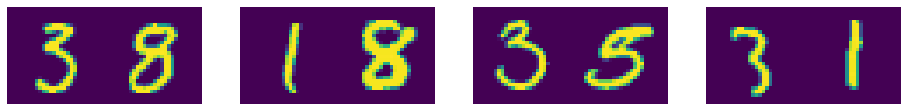

In [ ]:
nrows = 1
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4) 
x_df, y_df = getDoubleDigits(x_train,y_train,4) # CALL THE gDD FUNCTION TO CONSTRUCT A NEW
print("Answers:",y_df)                          # RANDOM SAMPLE OF 4 DOUBLE-DIGIT IMAGES

for i, img in enumerate(x_df):
    splot = plt.subplot(nrows, ncols, i + 1)
    splot.axis('Off')
    plt.imshow(img)
plt.show()


In [ ]:
# HERE IS WHERE WE CONSTRUCT 40000 DOUBLE-DIGIT IMAGES TO TRAIN ON
# PLUS ANOTHER 4000 IMAGES TO TEST ON AFTER TRAINING.

xts, yts = getDoubleDigits(x_test,y_test,4000)
x_test_normalized = np.array(xts) / 255.
y_test_norm = np.array(yts)
print("Made",4000,"new double-digit images to test on.")
xtn, ytn = getDoubleDigits(x_train,y_train,40000)
x_train_normalized = np.array(xtn) / 255.
y_train_norm = np.array(ytn)
print("Made",40000,"new double-digit images to train on.")
print("DONE!")
# WHEN ITS DONE IT WILL PRINT "DONE"!

Made 4000 new double-digit images to test on.
Made 40000 new double-digit images to train on.
DONE!


In [ ]:
train_6000 = np.array(xtn).reshape(28*56)
valid_2000 = np.array(xts).reshape(28*56)
train_6000["target"] = np.array(ytn) 
valid_4000["target"] = validation_targets
train_6000.to_csv("doubledigits_train_6000")
valid_2000.to_csv("doubledigits_valid_2000")

## Create a deep neural net model

[Text from the original project for single digits.]

The `create_model` function defines the topography of the deep neural net, specifying the following:

* The number of [layers](https://developers.google.com/machine-learning/glossary/#layer) in the deep neural net.
* The number of [nodes](https://developers.google.com/machine-learning/glossary/#node) in each layer.
* Any [regularization](https://developers.google.com/machine-learning/glossary/#regularization) layers.

The `create_model` function also defines the [activation function](https://developers.google.com/machine-learning/glossary/#activation_function) of each layer.  The activation function of the output layer is [softmax](https://developers.google.com/machine-learning/glossary/#softmax), which will yield (100) different outputs for each example. Each of the (100) outputs provides the probability that the input example is a certain digit.

In [ ]:

def create_model(learning_rate):
    """Create and compile a deep neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()

    # The double digit images are stored in two-dimensional arrays of 28x56 pixels 
    # each. The input layer flattens those two-dimensional arrays into 
    # one-dimensional 1568-element arrays.
    model.add(tf.keras.layers.Flatten(input_shape=(28, 56)))

    # The first interconnected layer will have 200 "neurons" (each of which 
    # is connected to each element in the input array). 
    # A "weight" will be randomly assigned to each node-to-node connection;
    # all those weights will get adjusted on each pass during training.
    # That's how the "learning" happens!
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    # This line will help keep the model from "overlearning" the training set,
    # which can happen, not good. 
    model.add(tf.keras.layers.Dropout(rate=0.3))

    # Define the second interconnected layer, this one with 100 "neurons".   
    model.add(tf.keras.layers.Dense(units=128, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=0.2))

    # Define the output layer. This layer must have exactly 100 "neurons", 
    # one for each possible output value (representing the numbers 0 to 99).
    # With Softmax activation, the model will assign each output node the
    # probability that the model thinks it's the corresponding double-digit number.
    # The one with the highest probability will then be chosen as the model's
    # "best guess" for each example given.
    model.add(tf.keras.layers.Dense(units=100, activation='softmax'))     
                            
    # Build the model with built-in metrics to measure the progress it's making
    # with the training set.  
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model 

# THIS FUNCTION WILL TRAIN THE MODEL ON THE TRAINING SET #
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):

    history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, 
                      validation_split=validation_split)
 
    # Get a snapshot of the model's metrics after each round of training
    # to measure its progress.
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist    

## Invoke the previous functions to train on the train set and evaluate on the test set.

Run the following code cell to invoke the preceding functions and actually train the model on the training set. 

In [ ]:
# These variables are the adjustable "hyperparameters" of the model.
learning_rate = 0.001
epochs = 20
batch_size = 500
validation_split = 0.1
# "epochs" is the number of times the model makes adjustments to all
# the weights for all the inter-neuron connections... which is a lot! 
# This should just take a couple of minutes; you can monitor its progress
# in the output window below.

# CREATE A NEW NEURAL NETWORK ACCORDING TO SPECIFICATIONS.
my_model = create_model(learning_rate)

# TRAIN IT ON THE "NORMALIZED" TRAINING SET:
epochs, hist = train_model(my_model, x_train_normalized, y_train_norm, 
                           epochs, batch_size, validation_split)

# EVALUATE AGAINST THE TEST SET:
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test_norm, batch_size=batch_size)

In [ ]:
x_train_normalized.shape


In [ ]:
# Plot a graph of the 'accuracy' metric vs. epochs:
plot_curve(epochs, hist, 'accuracy')

In [ ]:
# THIS FUNCTION TRANSLATES THE OUTPUT FROM THE NEURAL NETWORK
# INTO A "BEST GUESS" FOR EACH EXAMPLE BASED ON THE RELATIVE
# PROBABILITY IT ESTIMATES FOR EACH NUMBER 0 TO 99.

def getAnswers(how_many=10):  
    answers = pd.DataFrame(columns=['Answer','Guess','P(A)','P(G)'])  
    answers['Answer'] = y_test_norm[:how_many]
    predicts = my_model.predict(x_test_normalized).round(5)
    for j in range(0,how_many): # how_many is the number of examples to guess
        probs = predicts[j] # one row of 100 probabilities 
        maxr = max(probs)   # top probability
        for i in range(0,100):
            if probs[i] == maxr:
                answers.at[j,'Guess'] = i
                answers.at[j,'P(G)'] = maxr*100
            if i == answers['Answer'][j]:
                answers.at[j,'P(A)'] = probs[i]*100
    return answers
print("Loaded function getAnswers.")
print("Getting answers..." )

# LOAD UP ALL THE GUESSES (W/ PROBABILITES) FOR 
# EACH EXAMPLE IMAGE IN THE NORMALIZED TEST SET
answers = getAnswers(len(x_test_normalized))
answers

In [ ]:
# FIND THE *WRONG* GUESSES!
wrongs = pd.DataFrame(index=answers.index,columns=['Mask'])
for row in answers.index:
    if answers['Answer'][row] == answers['Guess'][row]:
        wrongs['Mask'][row] = False
    else:
        wrongs['Mask'][row] = True

# LOCATE AND PRINT OUT THE LIST OF WRONGS       
a = answers.loc[wrongs['Mask']]
w = len(a) 
t = len(x_test_normalized)
print(w,"wrong out of",t,"guesses.")
a

In [ ]:
# FIND OUT WHICH NUMBERS IT HAD THE MOST TROUBLE WITH
ww = []
for i in range(0,100):
    w = len((answers.loc[lambda a: a['Answer'] == i]).loc[wrongs['Mask']])
    ww += [w]
attempts = pd.DataFrame(ww)
attempts.sort_values(0).tail(5)

In [ ]:
# LAST BUT NOT LEAST...
# THIS CELL SHOWS WHAT SOME OF THE *WRONG* GUESSES WERE.
#
# IT SHOWS THE IMAGE THE ALGORITHM HAD TO WORK WITH
# ALONG WITH ITS "BEST GUESS" AND THE LABELED ANSWER

# RUN THE CELL A FEW TIMES TO SEE A FEW EXAMPLES OF WHERE IT FAILED!

g = answers['Guess'].loc[wrongs['Mask']]
a = answers['Answer'].loc[wrongs['Mask']]
x = rd.choice(g.index)  #RANDOMLY SELECT ONE OF THE WRONG GUESSES
pa = round(answers['P(A)'][x],2)
pg = round(answers['P(G)'][x],2)
print("Answer[",x,"] is",a[x],"with estimated probability",pa,"\n")
print("Guess[",x,"] was",g[x],"with estimated probability",pg,"\n")
plt.imshow(x_test_normalized[x])

And that's that, for now!

Next step: teach an algorithm to add and subtract just by giving it handwritten digits and handwritten "+","-","=" signs!!